In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

BASEDIR = "/data1/shahs3/users/sunge/cnv_simulator"
DATADIR = f"{BASEDIR}/data"
BAMDIR = f"{BASEDIR}/synthetic_bams_2"

## Define paths and read in files

In [3]:
test_name = "minitest_c2_1"
group_name = ""
bin_size = 5000

# Set up figure directory
FIGDIR = f"{BAMDIR}/{test_name}/figs"
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

# Read in the CNV profile
if group_name == "":
    cnv_profile_df = pd.read_csv(f"{BAMDIR}/{test_name}/{test_name}_cell_profile.tsv", sep="\t")
else:
    cnv_profile_df = pd.read_csv(f"{BAMDIR}/{test_name}/{test_name}_{group_name}_cnv_profile.tsv", sep="\t")

data_cnv_profile_df = cnv_profile_df.loc[cnv_profile_df["chr"] != 0]
clone_cnv_profile_df = cnv_profile_df.loc[cnv_profile_df["chr"] == 0]
clone_cell_count_lst = [
    len(row["cell_barcode"].split(","))
    for _, row in clone_cnv_profile_df.iloc[1:].iterrows()
]
print(f"Number of clones: {len(clone_cell_count_lst)}")
print(f"Number of cells in each clone: {clone_cell_count_lst}")

# Get cell barcode to index mapping
baseline_barcodes_str = cnv_profile_df[cnv_profile_df["clone"] == -1]["cell_barcode"].iloc[0]
baseline_barcodes = [x.strip() for x in baseline_barcodes_str.split(",")]
cell_idx_map = {cell_barcode: i for i, cell_barcode in enumerate(baseline_barcodes)}

# Get cell barcodes for each clone
clone_cell_id_dict = {}
clone_cell_idx_dict = {}
for _, clone in enumerate(clone_cnv_profile_df["clone"].unique()):
    if clone != -1:
        clone_cell_id_dict[f"clone{clone}"] = set(
            clone_cnv_profile_df.loc[clone_cnv_profile_df["clone"] == clone, "cell_barcode"].values[0].split(",")
        )

        clone_cell_idx_dict[f"clone{clone}"] = set(
            cell_idx_map[cb] for cb in clone_cell_id_dict[f"clone{clone}"] if cb in cell_idx_map
        ) 

# Load read depth matrix
read_depth_path = f"{BAMDIR}/{test_name}/{test_name}_final_sorted_cnv.bam.{bin_size}_read_depth.npz"
read_depth_mat = sp.load_npz(read_depth_path)
print(f"Read depth matrix shape: {read_depth_mat.shape}")

# Load bin labels
gene_windows_path = f"{DATADIR}/genome_{bin_size // 1000}kb_bins.bed"
bins = []
with open(gene_windows_path) as f:
    for line in f:
        chrom, start, end = line.strip().split()[:3]
        bins.append((chrom, int(start), int(end)))
bins = pd.DataFrame(bins, columns=["chrom", "start", "end"])


Number of clones: 2
Number of cells in each clone: [20, 10]
Read depth matrix shape: (620401, 30)


## Plotting helper functions

In [4]:
copynumber_colors = {
    "0": "#2C78B2",  # Dark blue
    "1": "#94C4DB",  # Light blue
    "2": "#C5C5C5",  # Gray
    "3": "#FCC484",  # Light orange
    "4": "#FA8154",  # Orange
    "5": "#DD4031",  # Red-orange
    "6": "#A9000D",  # Dark red
    "7": "#8C033A",  # Burgundy
    "8": "#6A1B9A",  # Medium purple
    "9": "#4A148C",  # Dark purple
    "10": "#38006B",  # Very dark purple
    "11": "#2E0057",  # Deep purple
    "12": "#240043",  # Almost black purple
    "13": "#1A002F",  # Darkest purple
    "14": "#12001C",  # Near-black purple
}

def plot_true_cnv(cnv_profile_df, n_cells_per_clone, save = True):
    num_clones = len(cnv_profile_df["clone"].unique())

    chr_lengths = cnv_profile_df.groupby("chr")["end"].max().sort_index()
    chr_offsets = chr_lengths.cumsum().shift(fill_value = 0).to_dict()
    chr_labels = {pos: chr for chr, pos in chr_offsets.items()}

    plot_df = cnv_profile_df.copy()
    plot_df.loc[:, "genome_start"] = plot_df.apply(
        lambda row: row["start"] + chr_offsets[row["chr"]], axis=1)
    plot_df.loc[:, "genome_end"] = plot_df.apply(
        lambda row: row["end"] + chr_offsets[row["chr"]], axis=1)

    fig, ax = plt.subplots(nrows = len(plot_df["clone"].unique()),
                        ncols = 1,
                        figsize = (10, 2 * num_clones))

    for i, clone in enumerate(plot_df["clone"].unique()):
        clone_df = plot_df[plot_df["clone"] == clone]
        for _, row in clone_df.iterrows():
            ax[i].plot(
                [row["genome_start"], row["genome_end"]],
                [row["state"], row["state"]],
                color = copynumber_colors[str(row["copy_number"])],
                alpha=0.7,
            )
        for offset in chr_offsets.values():
            ax[i].axvline(offset, color = "grey", linestyle = "--", linewidth = 0.5)

        ax[i].set_xticks(
            ticks = list(chr_offsets.values()),
            labels = list(chr_labels.values()),
            ha = "center"
        )

        ax[i].set_ylabel("Copy number")
        ax[i].set_title(f"Clone {clone} ({n_cells_per_clone[i]} cells)")

        ax[i].set_ylim(-2.5, 10)

    plt.tight_layout()
    plt.show()

    if save:
        fig.savefig(f"{FIGDIR}/true_cnv_profile.png", dpi = 300, bbox_inches = "tight")
        print(f"Saved figure to {FIGDIR}/true_cnv_profile.png")
        

def plot_read_depth_heatmap(read_depth_mat, clone_cell_idx_dict, clone_lst, bins, bin_mult, chr_lst, 
                            vmax = 100, save = True):

    clone_heatmap_data_lst = []
    row_colors = []

    clone_color_palette = sns.color_palette("tab10", n_colors = len(clone_lst))

    for clone in clone_lst:
        clone_idxs = sorted(clone_cell_idx_dict[f"clone{clone}"])
        chr_heatmap_data_lst = []
        for chr in chr_lst:
            chr_bin_idxs = bins[bins["chrom"] == chr].index.tolist()
            chr_heatmap_data = read_depth_mat.tocsr()[chr_bin_idxs, :][:, clone_idxs].toarray()
            nrows = chr_heatmap_data.shape[0]
            if nrows % bin_mult != 0:
                chr_heatmap_data = chr_heatmap_data[:nrows - nrows % bin_mult, :]
            chr_heatmap_data = chr_heatmap_data.reshape(-1, bin_mult, len(clone_idxs)).sum(axis = 1)
            chr_heatmap_data_lst.append(chr_heatmap_data.T)
        clone_heatmap_data = np.concatenate(chr_heatmap_data_lst, axis = 1)
        clone_heatmap_data_lst.append(clone_heatmap_data)
        row_colors.extend([clone_color_palette[int(clone)]] * clone_heatmap_data.shape[0])

    heatmap_data = np.concatenate(clone_heatmap_data_lst, axis = 0)

    chr_start_pos = []
    pos = 0
    for chr in chr_lst:
        n_bins = len(bins[bins["chrom"] == chr])
        chr_start_pos.append(pos)
        pos += n_bins // bin_mult
    
    plt.figure(figsize = (10, 5 * len(chr_lst)))
    cluster_plt = sns.clustermap(
        heatmap_data,
        cmap = "viridis",
        cbar_pos = (1.03, 0.6, 0.03, 0.2),
        cbar_kws = {"label": "Read depth"},
        row_cluster = False,
        col_cluster = False,
        dendrogram_ratio = (0.01, 0.01),
        xticklabels = False,
        yticklabels = False,
        row_colors = row_colors,
        vmax = vmax
    )
    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.ax_heatmap.set_xlabel("Bins")
    cluster_plt.ax_heatmap.set_xticks(chr_start_pos)
    cluster_plt.ax_heatmap.set_xticklabels(chr_lst)

    for xpos in chr_start_pos:
        cluster_plt.ax_heatmap.axvline(x = xpos, color = "white", linestyle = "-", linewidth = 1)

    if save:
        fig_name = f"read_depth_heatmap_bin{bin_size // 1000}kb.png"
        plt.savefig(f"{FIGDIR}/{fig_name}", dpi = 300, bbox_inches = "tight")

    plt.show()
    

## Plot simulated ground-truth CNV profiles

In [5]:
data_cnv_profile_df

,clone,chr,start,end,copy_number,state,size,cell_barcode,sample_group
3,0,1,0,46109263,2,0,46109263.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
4,0,1,46109263,50344133,2,0,4234870.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
5,0,1,50344133,125127088,2,0,74782955.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
6,0,1,125127088,131765669,0,-2,6638581.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
7,0,1,131765669,179079902,2,0,47314233.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
8,0,1,179079902,184596944,6,4,5517042.0,"128706A-R17-C28,128729A-R21-C45,A108753A-R13-C...","1,8,7,9,4,0,8,5,0,3,3,2,4,4,2,1,4,8,3,6,6,11,5..."
9,0,1,184596944,219041681,2,0,34444737.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
10,0,1,219041681,225497589,4,2,6455908.0,"128744A-R28-C27,128729A-R58-C43,128682A-R29-C4...","12,8,0,6,2,11,8,1,11,1,1,4,8,12,9,2,5,10,0,1,1..."
11,0,1,225497589,226261649,2,0,764060.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"
12,0,1,226261649,230117589,2,0,3855940.0,"A108762B-R45-C45,128726A-R57-C49,128624A-R22-C...","11,11,8,11,1,12,3,1,3,7,6,1,12,11,6,1,1,11,4,10"


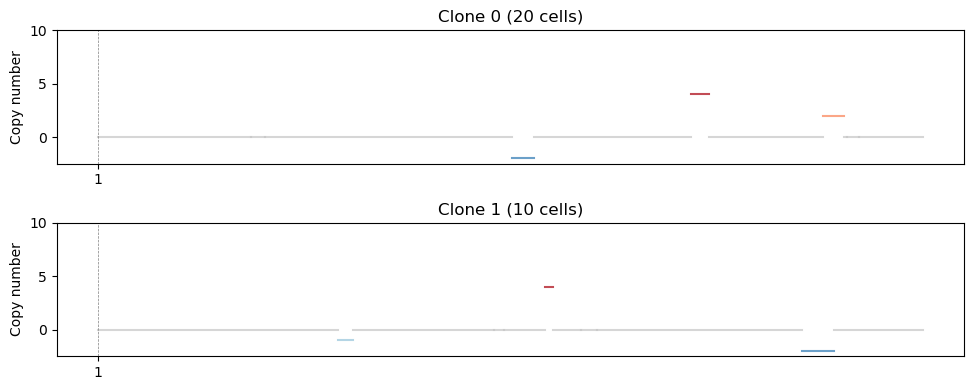

Saved figure to /data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/minitest_c2_1/figs/true_cnv_profile.png


In [6]:
plot_true_cnv(data_cnv_profile_df, clone_cell_count_lst, save = True)

<Figure size 1000x500 with 0 Axes>

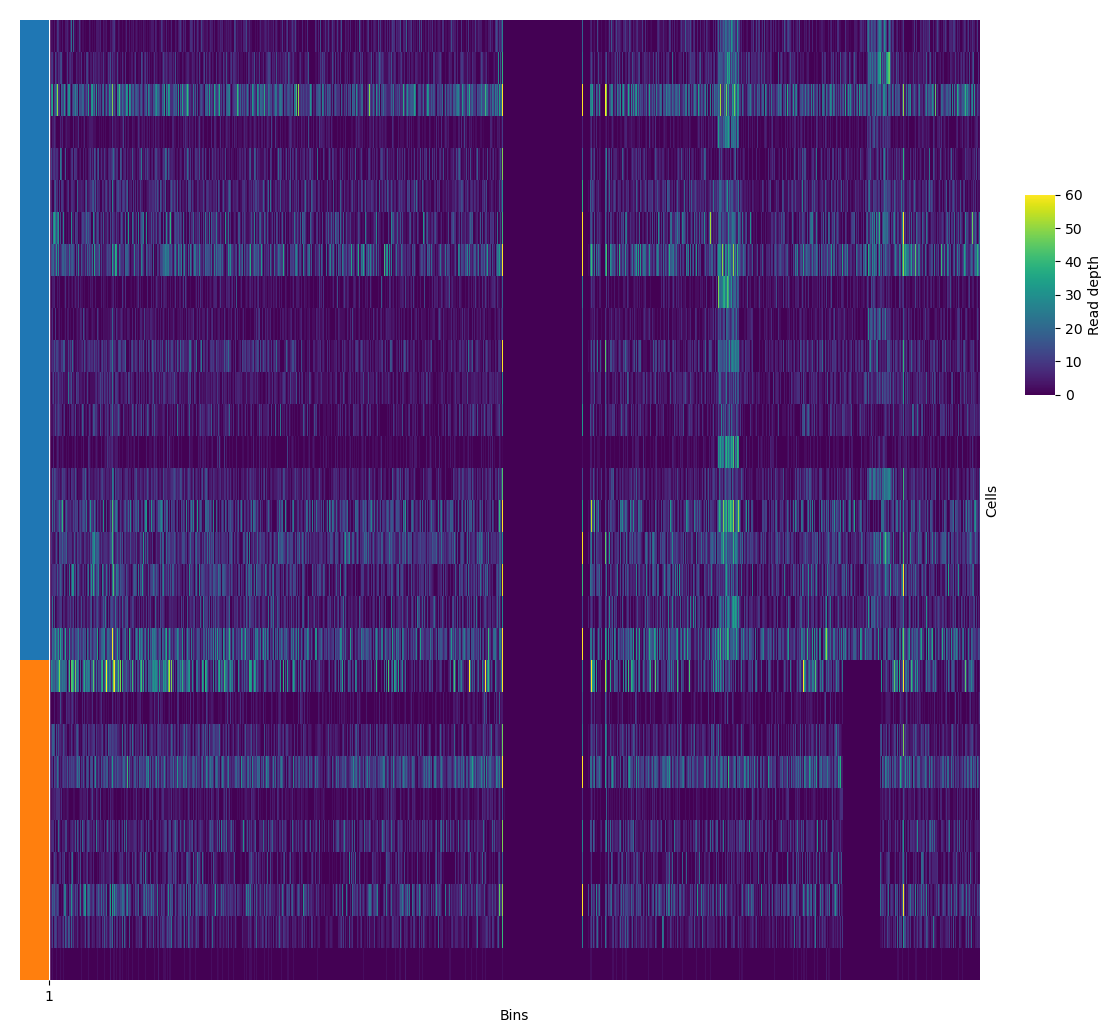

In [9]:
plot_read_depth_heatmap(
    read_depth_mat,
    clone_cell_idx_dict,
    clone_lst = [0, 1],
    bins = bins,
    bin_mult = 1,
    chr_lst = ["1"],
    vmax = 60,
    save = True
)

In [5]:
def plot_read_density_heatmap(cell_read_positions, bin_start, bin_end, num_bins = 50, vmax = None):
    """
    Plots a heatmap of read density in sub-bins for each cell.

    Args:
        cell_read_positions (dict): Dictionary mapping cell IDs to lists of read start positions.
        bin_start (int): Start coordinate of the bin.
        bin_end (int): End coordinate of the bin.
        num_bins (int): Number of sub-bins to divide the bin into.
    """
    print(bin_start, bin_end)

    # Initialize a matrix to store the histogram for each cell
    cell_ids = list(cell_read_positions.keys())
    cell_ids.sort()
    heatmap_data = np.zeros((len(cell_ids), num_bins))

    # Define bin edges
    bin_edges = np.linspace(bin_start, bin_end, num_bins + 1)

    # Populate the heatmap data
    for i, cell_id in enumerate(cell_ids):
        read_positions = np.array(cell_read_positions[cell_id])
        hist, _ = np.histogram(read_positions, bins=bin_edges)
        heatmap_data[i, :] = hist
    # Plot the heatmap
    plt.figure(figsize=(10, len(cell_ids) * 0.01))
    cluster_plt = sns.clustermap(
        heatmap_data, 
        cmap = "viridis",
        cbar = True,
        cbar_pos = (1.03, 0.6, 0.03, 0.2),
        row_cluster = True,
        col_cluster = False,
        xticklabels = False,
        yticklabels = False,
        dendrogram_ratio = (0.01, 0.01),
        vmax = vmax,
        cbar_kws = {"label": "Read Depth"}
    )
    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.ax_heatmap.set_title("Read Depth Heatmap")

    plt.show()
    return heatmap_data

def extract_read_positions(bam_file, chrom, start, end, cell_ids):
    """
    Extracts read start positions from a BAM file for a given genomic bin,
    grouped by cell (based on the RG tag).
    
    Args:
        bam_file (str): Path to the BAM file.
        chrom (str): Chromosome name (e.g., "chr1").
        start (int): Start coordinate of the bin.
        end (int): End coordinate of the bin.
    
    Returns:
        dict: A dictionary where keys are cell IDs (from RG tags) and values are lists of read start positions.
    """
    cell_reads = defaultdict(list)

    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for read in bam.fetch(chrom, start, end):
            
            if read.is_secondary or read.is_supplementary:
                continue  # Ignore secondary/supplementary alignments
            
            if read.is_read1 and read.has_tag("CB"):  
                cell_id = read.get_tag("CB")
                if cell_id in cell_ids: 
                    cell_reads[cell_id].append(read.reference_start)  # Store read start position

    return cell_reads


In [25]:
chr1_end = 249250621
chr2_end = 243199373

start_pos = 15953801 - 100000
end_pos = 21423141 + 100000

synthetic_bam_dir = f"{BASEDIR}/synthetic_bams_2"

clone0_chr1_baseline_read_pos = extract_read_positions(
    f"{synthetic_bam_dir}/{test_name}_baseline_cells.bam",
    "1",
    start_pos,
    end_pos,
    clone_cell_id_dict["clone0"]
)

# clone0_chr2_baseline_read_pos = extract_read_positions(
#     f"{synthetic_bam_dir}/{test_name}_baseline_cells.bam",
#     "2",
#     start_pos,
#     end_pos,
#     clone_cell_id_dict["clone0"]
# )

clone0_chr1_read_pos = extract_read_positions(
    f"{synthetic_bam_dir}/{test_name}_final_sorted_cnv.bam",
    "1",
    start_pos,
    end_pos,
    clone_cell_id_dict["clone0"]
)

# clone0_chr2_read_pos = extract_read_positions(
#     f"{synthetic_bam_dir}/{test_name}_final_sorted_cnv.bam",
#     "2",
#     start_pos,
#     end_pos,
#     clone_cell_id_dict["clone0"]
# )

15853801 21523141


/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x200 with 0 Axes>

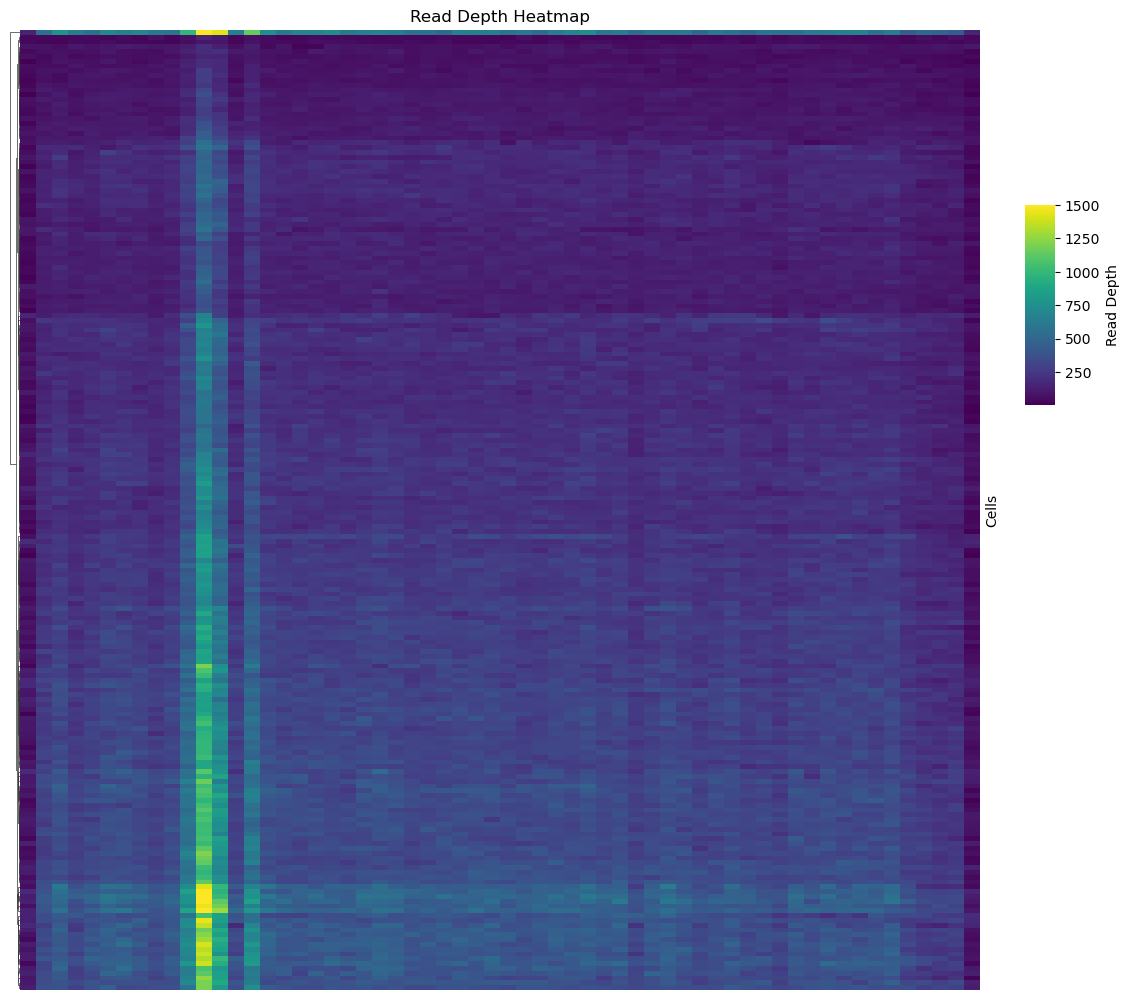

array([[ 92., 188., 297., ...,  81., 101.,  64.],
       [ 50., 114.,  88., ...,  81.,  68.,  36.],
       [186., 172., 242., ..., 174., 140., 163.],
       ...,
       [ 33., 140., 151., ..., 111., 106.,  20.],
       [ 35.,  21.,  25., ...,  48.,  27.,  45.],
       [  4.,  76., 121., ...,  49.,  61.,   3.]])

In [30]:
plot_read_density_heatmap(clone0_chr1_read_pos, start_pos, end_pos, num_bins = 60, vmax = 1500)